In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [19]:
#define paths to your dataset
train_dir = train_path = r"D:\Chest X-ray\Data\train"
val_dir=r"D:\Chest X-ray\Data\valid"
test_dir =r"D:\Chest X-ray\Data\test"
#Image dimensions 
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE =32 

In [20]:
#Training data augumentation
train_datagen = ImageDataGenerator(
    rescale=1./255, #Normalize pixels to 0-1
    rotation_range=20, #Randomly rotate images up to 20 degrees 
    width_shift_range=0.2, #Randomly shift images horizontally
    height_shift_range=0.2, #Randomly shift images vertically 
    shear_range=0.2, # shear transformation
    zoom_range=0.2, #Random zoom
    horizontal_flip=True,#randomly flip images
    fill_mode='nearest' #fill in missing pixels
)
#Validation and test data(no augmentation,only rescalling)
val_test_datagen = ImageDataGenerator(rescale=1./255)                                                                                 

In [21]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Two classes: Normal and Pneumonia
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


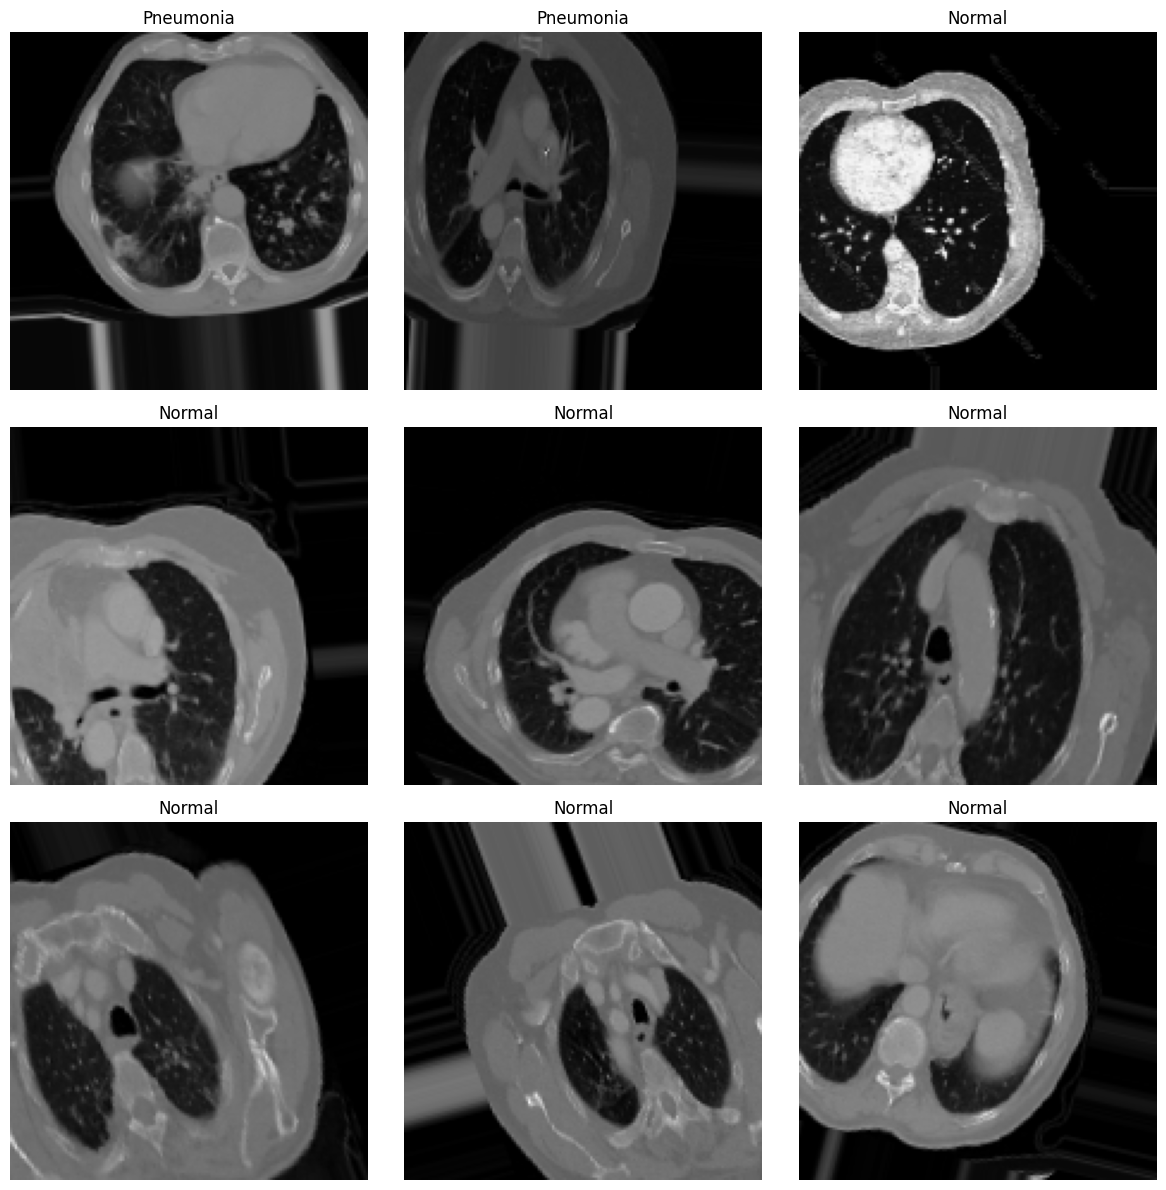

In [22]:
# Visualize some training images
def plot_images(generator, num_images=9):
    images, labels = next(generator)
    
    plt.figure(figsize=(12, 12))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title('Pneumonia' if labels[i] == 1 else 'Normal')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images
plot_images(train_generator)

In [23]:
def create_cnn_model():
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Fourth Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Flatten and Dense Layers
        Flatten(),
        Dropout(0.5),  # Prevents overfitting
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# Create the model
model = create_cnn_model()

# Display model architecture
model.summary()

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,529 (13.18 MB)

 Trainable params: 3,453,825 (13.18 MB)

 Non-trainable params: 704 (2.75 KB)

In [24]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_transfer_learning_model():
    # Load pre-trained VGG16 (without top classification layer)
    base_model = VGG16(
        weights='imagenet',  # Pre-trained on ImageNet
        include_top=False,   # Remove classification layer
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    
    # Freeze base model layers (don't retrain them)
    base_model.trainable = False
    
    # Add custom classification layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model, base_model

# Create transfer learning model
transfer_model, base_model = create_transfer_learning_model()
transfer_model.summary()

# Compile
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
# Early Stopping: Stop if model stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,              # Wait 5 epochs before stopping
    restore_best_weights=True
)

# Reduce Learning Rate: Slow down when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # Reduce LR by 50%
    patience=3,
    min_lr=1e-7
)

callbacks = [early_stop, reduce_lr]

In [28]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

# Train the model
EPOCHS = 25

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.2069 - loss: -64.7078 - val_accuracy: 0.3594 - val_loss: 13.9744 - learning_rate: 0.0010
Epoch 2/25
 1/19 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.1562 - loss: -294.2779

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.1562 - loss: -294.2779 - val_accuracy: 0.3594 - val_loss: 12.7535 - learning_rate: 0.0010
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.1742 - loss: -681.0352 - val_accuracy: 0.3594 - val_loss: 18.1321 - learning_rate: 0.0010
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.1562 - loss: -756.1488 - val_accuracy: 0.3594 - val_loss: 18.3809 - learning_rate: 0.0010
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.2440 - loss: -2073.5291 - val_accuracy: 0.4219 - val_loss: 0.4444 - learning_rate: 0.0010
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.1875 - loss: -4772.9907 - val_accuracy: 0.3281 - val_loss: 0.5728 - learning_rate: 0.0010
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.1911 - loss: -5411.6553 - val_accuracy: 0.3281 - val_loss: -61.3185 - learning_rate: 0.0010
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.2812 - loss: -77

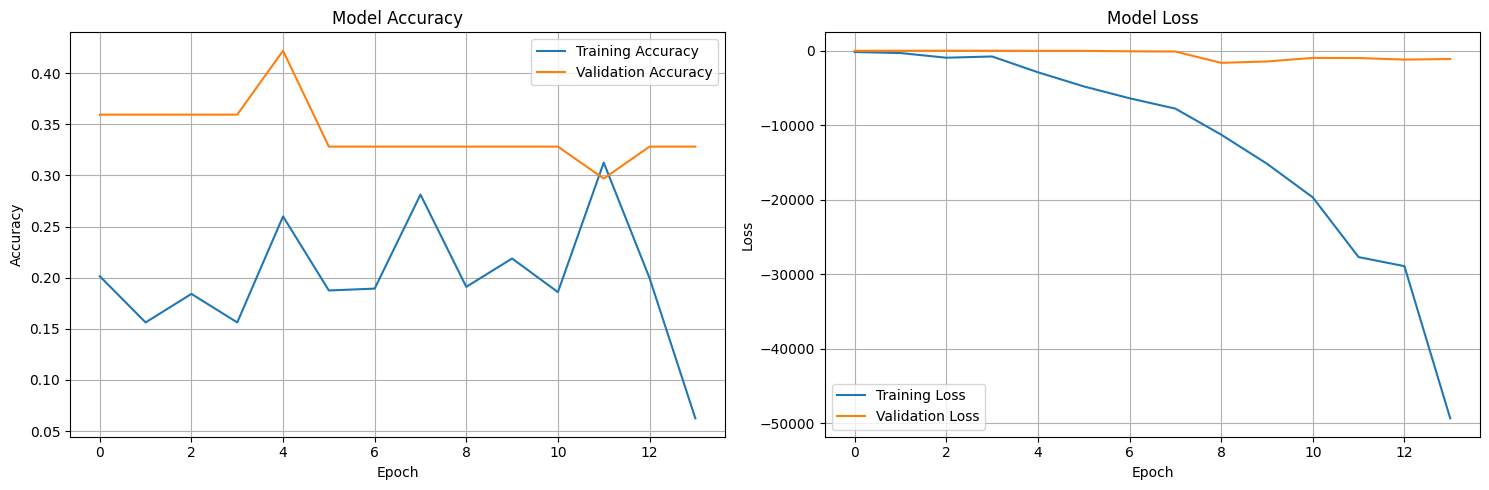

In [29]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualize training
plot_training_history(history)

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get true labels
true_classes = test_generator.classes

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, 
                            target_names=['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']))


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step
Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.00      0.00      0.00       120
   large.cell.carcinoma       0.16      1.00      0.28        51
                 normal       0.00      0.00      0.00        54
squamous.cell.carcinoma       0.00      0.00      0.00        90

               accuracy                           0.16       315
              macro avg       0.04      0.25      0.07       315
           weighted avg       0.03      0.16      0.05       315



C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classif

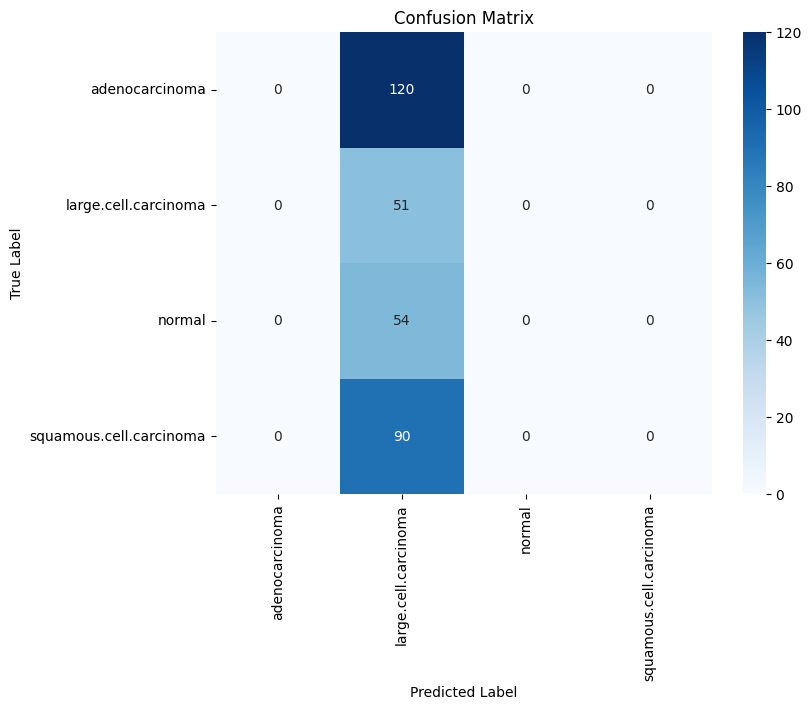

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.00      0.00      0.00       120
   large.cell.carcinoma       0.16      1.00      0.28        51
                 normal       0.00      0.00      0.00        54
squamous.cell.carcinoma       0.00      0.00      0.00        90

               accuracy                           0.16       315
              macro avg       0.04      0.25      0.07       315
           weighted avg       0.03      0.16      0.05       315



C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classif

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Class labels (update as per your dataset folders)
labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report (includes precision, recall, f1-score automatically)
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=labels))


In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
accuracy = accuracy_score(true_classes, predicted_classes)

print(f"\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Overall Metrics:
Accuracy: 0.1619
Precision: 0.0405
Recall (Sensitivity): 0.2500
F1 Score: 0.0697


C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [62]:
predicted_index = np.argmax(predictions)
result = CLASS_NAMES[predicted_index]


In [63]:
print(train_generator.class_indices)


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


In [64]:
print("Train:", train_generator.class_indices)
print("Test:", test_generator.class_indices)
print("Validation:", val_generator.class_indices)


Train: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
Test: {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
Validation: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


In [66]:
Dense(4, activation='softmax')
loss='categorical_crossentropy'



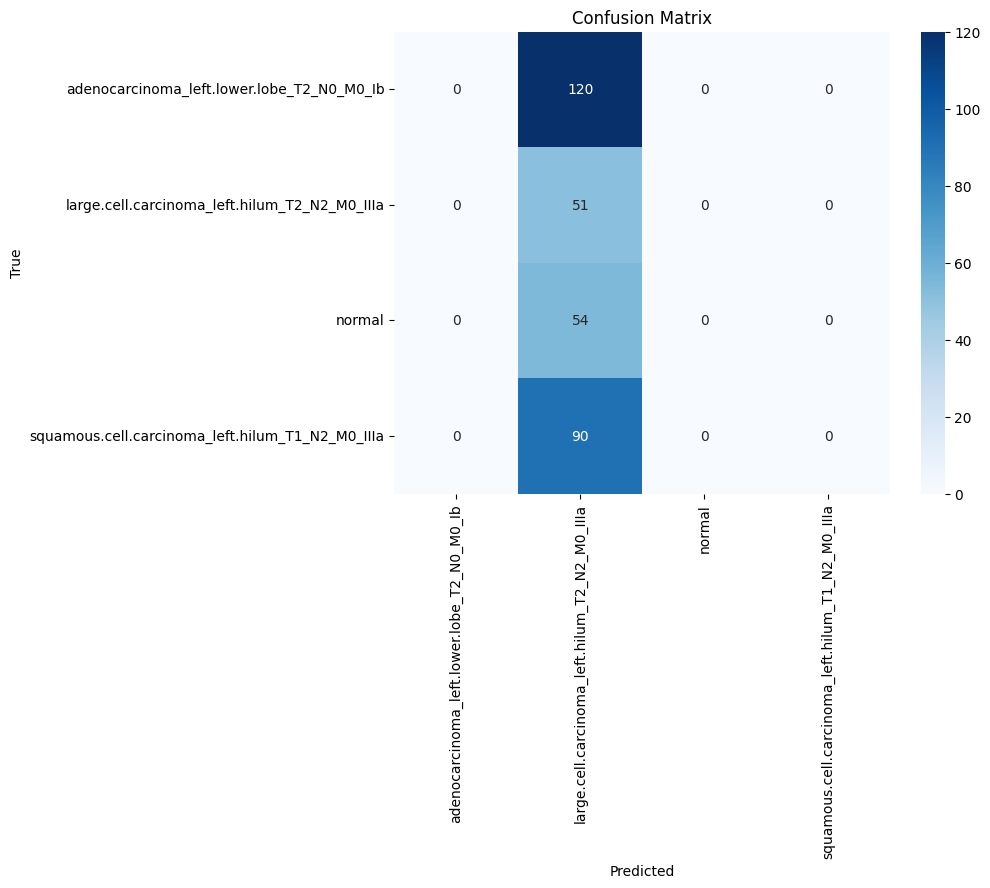

In [67]:
classes = [
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
    'normal',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
]

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [81]:
model.input_shape


(None, 150, 150, 3)

In [82]:
IMG_HEIGHT = 150
IMG_WIDTH = 150


In [83]:
print("Model input shape:", model.input_shape)


Model input shape: (None, 150, 150, 3)


In [84]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

label_map = {
    0: 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
    1: 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
    2: 'normal',
    3: 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
}

def predict_chest_xray(img_path, model):
    # Auto-detect expected input size
    _, img_height, img_width, _ = model.input_shape

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction) * 100

    # Display result
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {label_map[predicted_class]}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

    return label_map[predicted_class], confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


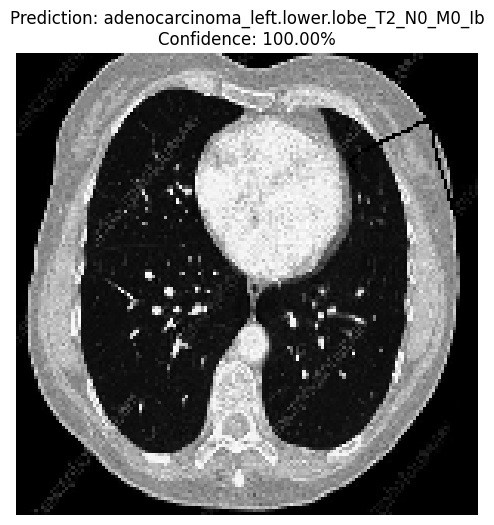

Result: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib (100.00% confidence)


In [85]:
img_path = r'D:\Chest X-ray\Data\test\normal\6 - Copy.png'
result, confidence = predict_chest_xray(img_path, model)
print(f"Result: {result} ({confidence:.2f}% confidence)")


In [87]:
# Save weights
model.save_weights('model.weights.h5')

# Load weights
model.load_weights('model.weights.h5')


In [89]:
# Save the entire model
model.save('pneumonia_detection_model.h5')
print("Model saved successfully!")

# Load the model later
from tensorflow.keras.models import load_model
loaded_model = load_model('pneumonia_detection_model.h5')
print("Model loaded successfully!")
# Save weights
model.save_weights('model.weights.h5')

# Load weights
model.load_weights('model.weights.h5')

Model saved successfully!


Model loaded successfully!
